# Notebook to demonstrate plotting of station models

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.polarimetric as dualpol
import pyPIPS.timemodule as ptime
# from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
# from pyCRMtools.pycaps import arps_read
# from pyCRMtools.pycaps import pycaps_fields
# from pyCRMtools.pycaps import calvars_radar as radar

# Stesonet plotting stuff. Need to add location to the path

sys.path.append('/Users/dawson29/Projects/StickNet_Repo')
from functions import calc_dewpoint,calc_thetae,calc_thetav,C_to_F,calc_mslp,convert_wind, parse_currtime
from functions_plotting import scale_bar, plot_logo

import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from metpy.plots import USCOUNTIES
from metpy.plots import StationPlot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# from natsort import natsorted
from pprint import pprint
from adjustText import adjust_text
import warnings
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
matplotlib.style.use('seaborn-v0_8-bright')

# # read in cartopy information    
crs = ccrs.PlateCarree()
# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='10m',
        facecolor='none')


%config InlineBackend.figure_format='retina'

In [3]:


def read_StickNet_locs_to_xarray(filepath):
    """Given the path to the StickNet locations file, read it into an xarray Dataset"""
    df = pd.read_csv(filepath)
    ds = df.to_xarray()
    ds = ds.assign_coords(ID=('index', ds['ID'].to_numpy()))
    ds = ds.swap_dims({'index': 'ID'})

    return ds

def read_StickNet_level3_to_xarray(dir, deployment_name, probe_id, loc_ds):
    """Given the directory containing the level3 files and an xarray Dataset containing the location information,
       read the data into an xarray Dataset"""
    probe_filename = f"0{probe_id}_{deployment_name}_level3.txt"
    probe_filepath = os.path.join(dir, probe_filename)
    probe_df = pd.read_csv(probe_filepath)
    # Set the time index
    probe_df['Time'] = pd.DatetimeIndex(probe_df['Time'])
    probe_df.set_index("Time", inplace=True)
    probe_ds = probe_df.to_xarray()

    # Set location, probe id, start and end times, etc., as attributes
    probe_ds.attrs['probe_name'] = probe_id
    lat = loc_ds.sel(ID=probe_id)['Latitude'].to_numpy().item()
    lon = loc_ds.sel(ID=probe_id)['Longitude'].to_numpy().item()
    elev = loc_ds.sel(ID=probe_id)['Elevation'].to_numpy().item()
    location_tuple = (lat, lon, elev)
    probe_ds.attrs['location'] = str(location_tuple)
    probe_ds.attrs['Array_Type'] = "Fine"
    starting_time = probe_ds['Time'][0].dt.strftime("%Y%m%d%H%M%S").item()
    ending_time = probe_ds['Time'][-1].dt.strftime("%Y%m%d%H%M%S").item()
    probe_ds.attrs['starting_time'] = starting_time
    probe_ds.attrs['ending_time'] = ending_time

    return probe_ds

In [4]:
# date = '052516' # '053122' # '030622' # '061416'
# PIPS_dir = '/Users/dawson29/Dropbox/PIPS_data/2016/{}/netcdf'.format(date)
# PIPS_dir = '/Users/dawson29/Dropbox/Projects/PERiLS/PIPS_data/{}_IN_test/netcdf'.format(date)
# PIPS_dir = '/Users/dawson29/Dropbox/Projects/PERiLS/PIPS_data/IOP2_033022/netcdf'
# PIPS_dir = '/Users/dawson29/Dropbox/PIPS_data/2023/IOP2_030323/netcdf'
PIPS_dir = '/Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/IOP2_033022/netcdf'
# PIPS_dir = '/Users/dawson29/Projects/PERiLS/obsdata/2023/PIPS_data/IOP3_032423/netcdf'
# PIPS_dir = '/Users/dawson29/Projects/PERiLS/obsdata/2023/PIPS_data/IOP4_033123/netcdf'
# PIPS_dir = '/Users/dawson29/Projects/PERiLS/obsdata/2023/PIPS_data/IOP5_040523/netcdf'
# PIPS_dir = '/Users/dawson29/Dropbox/Teaching/2022/EAPS_591_SSFW/PIPS_data/{}/netcdf'.format(date)
# PIPS_dir = '/depot/dawson29/data/Projects/SPOTTR-2016/{}/obsdata/PIPS/netcdf'.format(date)
# PIPS_dir = '/Users/dawson29/Dropbox/PIPS_data/2016/SPOTTR2016/{}/netcdf'.format(date)
# PIPS_dir = '/Users/dawson29/PIPS_data/2023/031123_mass_test/netcdf'
# PIPS_dir = '/Users/dawson29/Dropbox/PIPS_data/2023/022223_mass_test/netcdf'
# PIPS_dir = '/Users/dawson29/PIPS_data/2023/031623_mass_test/netcdf'
# deployment_name = 'SPOTTR_{}'.format(date)
# deployment_name = '031123_mass_test'
# deployment_name = '022223_mass_test'
# deployment_name = '031623_mass_test'
# deployment_name = 'IOP3_032423'
# deployment_name = 'IOP4_033123'
# deployment_name = 'IOP5_040523'
deployment_name = 'IOP2_033022'
# PIPS_names = ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS2B', 'PIPS3A', 'PIPS3B']
PIPS_names = ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS3B']
parsivel_interval = 10
parsivel_filenames = ['parsivel_combined_{}_{}_{:d}s.nc'.format(deployment_name, PIPS_name, parsivel_interval)
                      for PIPS_name in PIPS_names]
parsivel_filepaths = [os.path.join(PIPS_dir, parsivel_filename) for parsivel_filename in parsivel_filenames]
conv_filenames = ['conventional_raw_{}_{}.nc'.format(deployment_name, PIPS_name) for PIPS_name in PIPS_names]
conv_filepaths = [os.path.join(PIPS_dir, conv_filename) for conv_filename in conv_filenames]
parsivel_ds_read_dict = {}
conv_ds_read_dict = {}
for PIPS_name, parsivel_filepath, conv_filepath in zip(PIPS_names, parsivel_filepaths, conv_filepaths):
    try:
        parsivel_ds_read_dict[PIPS_name] = xr.load_dataset(parsivel_filepath)
    except:
        parsivel_ds_read_dict[PIPS_name] = None
    conv_ds_read_dict[PIPS_name] = xr.load_dataset(conv_filepath)

In [5]:
# Read in StickNet data (level 3)

stick_dir = "/Users/dawson29/Projects/PERiLS/obsdata/2022/TTU_StickNet"
IOP_name = "IOP2"

location_file = f"{IOP_name}_StickNet_Locations.csv"
location_path = os.path.join(stick_dir, location_file)

sticknet_locs_ds = read_StickNet_locs_to_xarray(location_path)
sticknet_fine_locs_ds = sticknet_locs_ds.where(sticknet_locs_ds['Array_Type'] == 'Fine', drop=True)
sticknet_fine_ids = sticknet_fine_locs_ds['ID'].to_numpy()
sticknet_ds_list = [read_StickNet_level3_to_xarray(stick_dir, IOP_name, probe_id, sticknet_fine_locs_ds) for probe_id in sticknet_fine_ids]
sticknet_ds_dict = {stick_id: stick_ds for stick_id, stick_ds in zip(sticknet_fine_ids, sticknet_ds_list)}

In [6]:
for PIPS_name in PIPS_names:
    conv_ds = conv_ds_read_dict[PIPS_name]
    print(PIPS_name)
    print(conv_ds['time'][0].values, conv_ds['time'][-1].values)
    geo_loc = eval(str(conv_ds.location))
    lat = float(geo_loc[0])
    lon = float(geo_loc[1])
    alt = float(geo_loc[2])
    print(f'{lat:0.5f}, {lon:0.5f}, {alt:0.0f}')

for stick_name in sticknet_fine_ids:
    stick_ds = sticknet_ds_dict[stick_name]
    print(stick_name)
    print(stick_ds['Time'][0].values, stick_ds['Time'][-1].values)
    geo_loc = eval(str(stick_ds.location))
    lat = float(geo_loc[0])
    lon = float(geo_loc[1])
    alt = float(geo_loc[2])
    print(f'{lat:0.5f}, {lon:0.5f}, {alt:0.0f}')


PIPS1A
2022-03-30T23:49:25.000000000 2022-03-31T01:25:33.000000000
33.75801, -88.44617, 71
PIPS1B
2022-03-30T23:41:43.000000000 2022-03-31T01:33:10.000000000
33.71500, -88.45050, 67
PIPS2A
2022-03-30T23:58:49.000000000 2022-03-31T01:11:48.000000000
33.82967, -88.45933, 74
PIPS3B
2022-03-30T23:59:47.000000000 2022-03-31T01:14:19.000000000
33.82967, -88.45933, 74
103A
2022-03-30T23:43:00.000000000 2022-03-31T01:46:21.000000000
33.71499, -88.45048, 72
104A
2022-03-31T00:05:00.000000000 2022-03-31T01:06:38.000000000
33.81864, -88.46109, 74
110A
2022-03-30T23:49:54.000000000 2022-03-31T01:34:33.000000000
33.75744, -88.44523, 77
111A
2022-03-30T23:55:52.000000000 2022-03-31T01:25:09.000000000
33.78555, -88.45847, 69
213A
2022-03-30T23:52:32.000000000 2022-03-31T01:22:30.000000000
33.77025, -88.45632, 71
214A
2022-03-30T23:58:46.000000000 2022-03-31T01:13:34.000000000
33.80082, -88.46251, 70
220A
2022-03-30T23:42:55.000000000 2022-03-31T01:38:56.000000000
33.72865, -88.44127, 87
221A
2022-03-

In [7]:
sticknet_ds_dict['103A']

<xarray.Dataset> Size: 355kB
Dimensions:  (Time: 7402)
Coordinates:
  * Time     (Time) datetime64[ns] 59kB 2022-03-30T23:43:00 ... 2022-03-31T01...
Data variables:
    T        (Time) float64 59kB 21.8 21.8 21.9 21.9 ... 17.2 17.2 17.2 17.2
    RH       (Time) float64 59kB 81.3 81.4 81.5 81.5 ... 93.0 93.0 93.0 93.0
    P        (Time) float64 59kB 991.9 992.0 992.0 991.9 ... 993.5 993.5 993.5
    WS       (Time) float64 59kB 5.8 5.4 5.2 5.2 6.6 6.2 ... 3.2 3.2 3.2 3.2 3.2
    WD       (Time) float64 59kB 173.3 169.5 174.2 202.0 ... 179.5 167.6 180.0
Attributes:
    probe_name:     103A
    location:       (33.714987, -88.450477, 72.4)
    Array_Type:     Fine
    starting_time:  20220330234300
    ending_time:    20220331014621

In [8]:
# Restrict to certain time range
# start_time = '2022-05-31T23:00' # '2022-03-07T00:00'
# end_time = '2022-06-01T00:05' # '2022-03-08T00:00'
# start_time = '2022-03-30T23:40'
# end_time = '2022-03-31T01:30'
# start_time = '2023-03-12T00:15'
# end_time = '2023-03-12T14:00'
# start_time = '2023-02-22T16:00'
# end_time = '2023-02-23T01:00'
# start_time = '2023-03-16T17:45'
# end_time = '2023-03-17T15:05'

if False:
    parsivel_ds_dict = {}
    conv_ds_dict = {}
    for PIPS_name in PIPS_names:
        try:
            parsivel_ds_dict[PIPS_name] = parsivel_ds_read_dict[PIPS_name].sel(time=slice(start_time, end_time))
        except AttributeError:
            parsivel_ds_dict[PIPS_name] = None
        conv_ds_dict[PIPS_name] = conv_ds_read_dict[PIPS_name].sel(time=slice(start_time, end_time))
else:
    parsivel_ds_dict = parsivel_ds_read_dict
    conv_ds_dict = conv_ds_read_dict

In [9]:
parsivel_ds_dict['PIPS2A']

datetimes = parsivel_ds_dict['PIPS2A']['time'].to_index().to_pydatetime()

print(datetimes)

[datetime.datetime(2022, 3, 30, 23, 59, 3)
 datetime.datetime(2022, 3, 30, 23, 59, 13)
 datetime.datetime(2022, 3, 30, 23, 59, 23)
 datetime.datetime(2022, 3, 30, 23, 59, 33)
 datetime.datetime(2022, 3, 30, 23, 59, 43)
 datetime.datetime(2022, 3, 30, 23, 59, 53)
 datetime.datetime(2022, 3, 31, 0, 0, 3)
 datetime.datetime(2022, 3, 31, 0, 0, 13)
 datetime.datetime(2022, 3, 31, 0, 0, 23)
 datetime.datetime(2022, 3, 31, 0, 0, 33)
 datetime.datetime(2022, 3, 31, 0, 0, 43)
 datetime.datetime(2022, 3, 31, 0, 0, 53)
 datetime.datetime(2022, 3, 31, 0, 1, 3)
 datetime.datetime(2022, 3, 31, 0, 1, 13)
 datetime.datetime(2022, 3, 31, 0, 1, 23)
 datetime.datetime(2022, 3, 31, 0, 1, 33)
 datetime.datetime(2022, 3, 31, 0, 1, 43)
 datetime.datetime(2022, 3, 31, 0, 1, 53)
 datetime.datetime(2022, 3, 31, 0, 2, 3)
 datetime.datetime(2022, 3, 31, 0, 2, 13)
 datetime.datetime(2022, 3, 31, 0, 2, 23)
 datetime.datetime(2022, 3, 31, 0, 2, 33)
 datetime.datetime(2022, 3, 31, 0, 2, 43)
 datetime.datetime(2022, 3

In [10]:
# Get a particular time to plot
# time_to_plot = '2022-03-31T00:15' # '2023-04-05T17:00' # '2023-03-03T08:30'# '2022-03-31T00:15'
# parsivel_ds_to_plot_dict = {}

# for PIPS_name, parsivel_ds in parsivel_ds_dict.items():
#     try:
#         parsivel_ds_to_plot_dict[PIPS_name] = parsivel_ds.sel(time=time_to_plot, method='nearest')
#     except AttributeError:
#         parsivel_ds_to_plot_dict[PIPS_name] = None
    
# obtime = parsivel_ds_to_plot_dict['PIPS2A']['time'].values
# obtime = pd.to_datetime(obtime)
# print(obtime)

# print(parsivel_ds_to_plot_dict)


In [11]:
# Get a particular time to plot
time_to_plot =  '2022-03-31T00:15' # '2023-04-05T17:00' # '2023-03-03T08:30'# '2022-03-31T00:15'
conv_ds_to_plot_dict = {}

for PIPS_name, conv_ds in conv_ds_dict.items():
    try:
        conv_ds_to_plot_dict[PIPS_name] = conv_ds.sel(time=time_to_plot, method='nearest')
    except AttributeError:
        conv_ds_to_plot_dict[PIPS_name] = None

stick_ds_to_plot_dict = {}
for stick_name, stick_ds in sticknet_ds_dict.items():
    stick_ds_to_plot_dict[stick_name] = stick_ds.sel(Time=time_to_plot, method='nearest')

obtime = conv_ds_to_plot_dict['PIPS2A']['time'].values
obtime = pd.to_datetime(obtime)
print(obtime)


all_names = np.concatenate([PIPS_names, sticknet_fine_ids])

all_ds_dict = {**conv_ds_to_plot_dict, **stick_ds_to_plot_dict}

2022-03-31 00:15:00


In [12]:
# T_list = []
# Td_list = []
# pressure_list = []
# u_list = []
# v_list = []
# lats = []
# lons = []
# elevs = []

# for PIPS_name, parsivel_ds in parsivel_ds_to_plot_dict.items():
#     geo_loc_str = parsivel_ds.location
#     geo_loc = list(map(float, geo_loc_str.strip('()').split(',')))
#     lats.append(geo_loc[0])
#     lons.append(geo_loc[1])
#     elevs.append(geo_loc[2])
    
#     T_list.append(parsivel_ds['fasttemp'].values)
#     Td_list.append(parsivel_ds['dewpoint'].values)
#     pressure_list.append(parsivel_ds['pressure'].values)
#     u_list.append(parsivel_ds['uavg'].values)
#     v_list.append(parsivel_ds['vavg'].values)

# T_arr = np.array(T_list)
# Td_arr = np.array(Td_list)
# pressure_arr = np.array(pressure_list)
# u_arr = np.array(u_list)
# v_arr = np.array(v_list)
    

In [13]:
T_list = []
Td_list = []
pressure_list = []
u_list = []
v_list = []
lats = []
lons = []
elevs = []

for PIPS_name, conv_ds in conv_ds_to_plot_dict.items():
    geo_loc_str = conv_ds.location
    geo_loc = list(map(float, geo_loc_str.strip('()').split(',')))
    lats.append(geo_loc[0])
    lons.append(geo_loc[1])
    elevs.append(geo_loc[2])
    
    T_list.append(conv_ds['fasttemp'].values)
    Td_list.append(conv_ds['dewpoint'].values)
    pressure_list.append(conv_ds['pressure'].values)
    u = conv_ds['windspd'] * np.cos(np.deg2rad(-conv_ds['winddirabs'] + 270.))
    v = conv_ds['windspd'] * np.sin(np.deg2rad(-conv_ds['winddirabs'] + 270.))
    u_list.append(u.values)
    v_list.append(v.values)

# Append StickNet data
for stick_name, stick_ds in stick_ds_to_plot_dict.items():
    geo_loc_str = stick_ds.location
    geo_loc = list(map(float, geo_loc_str.strip('()').split(',')))
    lats.append(geo_loc[0])
    lons.append(geo_loc[1])
    elevs.append(geo_loc[2])

    T = stick_ds['T'].to_numpy()
    p = stick_ds['P'].to_numpy()
    RH = stick_ds['RH'].to_numpy()
    ws = stick_ds['WS'].to_numpy()
    wd = stick_ds['WD'].to_numpy()
    T_list.append(T)
    Td = thermo.calTdfromRH(p * 100., T + 273.15, RH / 100.) - 273.15
    Td_list.append(Td)
    pressure_list.append(p)
    u = ws * np.cos(np.deg2rad(-wd + 270.))
    v = ws * np.sin(np.deg2rad(-wd + 270.))
    u_list.append(u)
    v_list.append(v)

T_arr = np.array(T_list)
Td_arr = np.array(Td_list)
pressure_arr = np.array(pressure_list)
u_arr = np.array(u_list)
v_arr = np.array(v_list)



In [14]:
### find extent of plot
# exact center of plot
clat = np.amin(lats)+ abs(np.amax(lats) - np.amin(lats))/2
clon = np.amin(lons) + abs(np.amin(lons) - np.amax(lons))/2

# NOTE: change these hardcoded values if you want to change relative domain size
# larger (smaller) numbers = larger (smaller) domain
dlat = 0.75 * abs(np.amax(lats) - np.amin(lats))
dlon = 0.75 * abs(np.amin(lons) - np.amax(lons))


if dlon < .1:
    dlon = .1
if dlat < .1:
    dlat = .1

# find corners using the center and the buffers
north_lat, south_lat = clat+dlat, clat-dlat
west_lon, east_lon = clon-dlon, clon+dlon


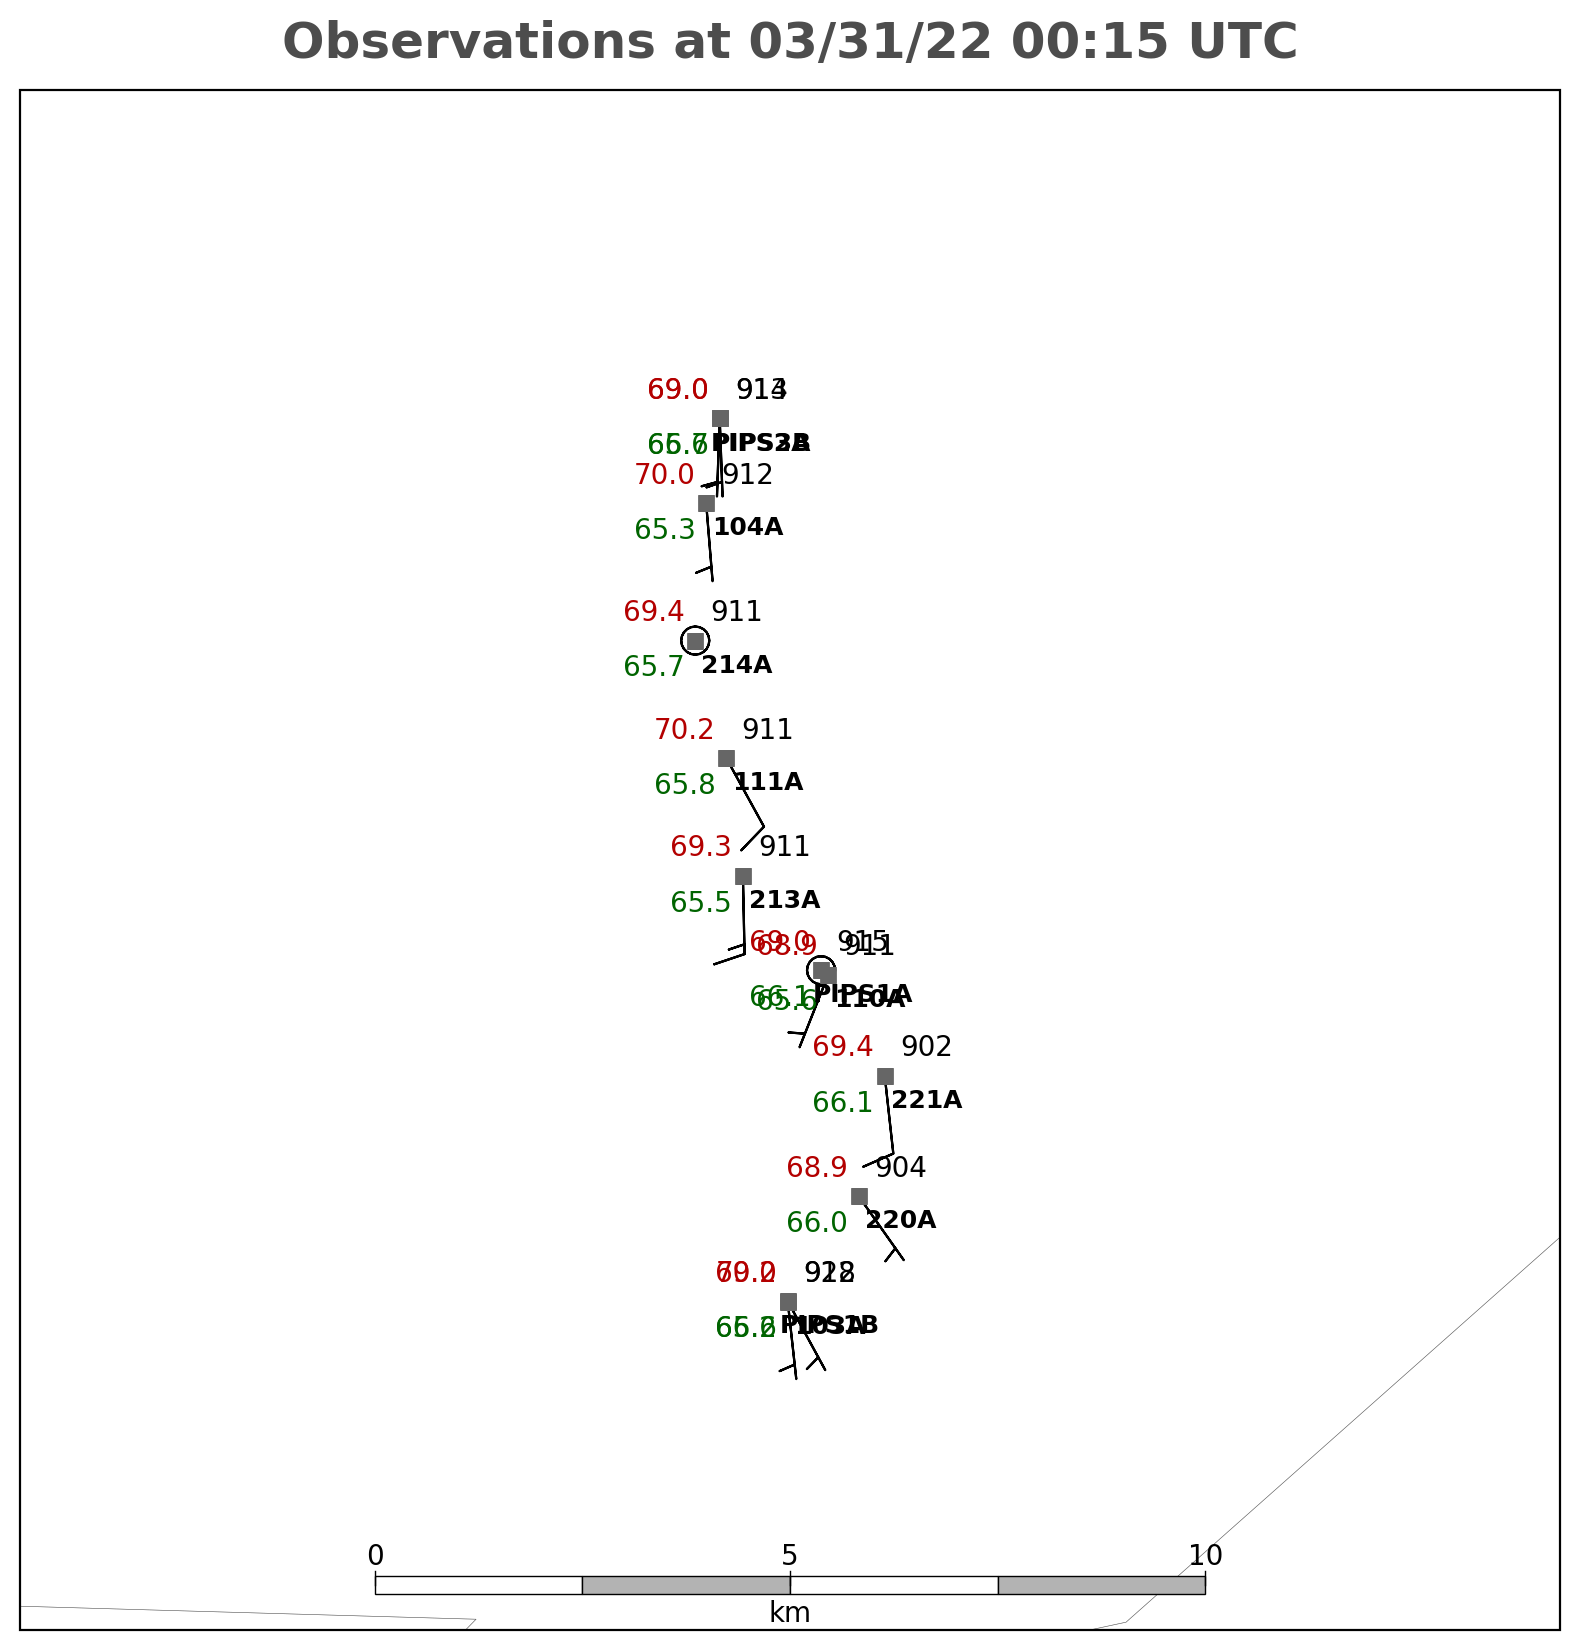

In [15]:
### initialize figure
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(1,1,1, projection=crs)
ax.set_extent([west_lon, east_lon, north_lat,south_lat], crs )
ax.add_feature(states_provinces, edgecolor='k', alpha=0.25, linewidth=1)
ax.add_feature(USCOUNTIES.with_scale('20m'), alpha=0.4, linewidth=0.2)


# mark locations of SN
ax.plot(lons,lats,marker='s',color='0.4',markersize=5, linewidth=0)


# use metpy to plot T, Td, MSLP (coded), and the 4-letter identifiers
stationplot = StationPlot(ax, lons, lats, clip_on=True, transform=crs, fontsize=10)
stationplot.plot_parameter((-1.5,1), C_to_F(T_arr), color='#b30000', formatter='0.1f')
stationplot.plot_parameter((-1.5,-1), C_to_F(Td_arr), color='darkgreen', formatter='0.1f')
stationplot.plot_parameter((1.5,1), pressure_arr, formatter=lambda v: format(10 * v, '.0f')[-3:])
stationplot.plot_text((1.5, -.9), all_names, fontsize=9, weight='bold')

# Add wind barbs, dropping bad vals, cuz WS can == -999
# u[abs(u)>60] = 0; v[abs(v)>60] = 0
ax.barbs(lons, lats, u_arr, v_arr, length=7.5, sizes={'emptybarb':.18}, lw=0.8)
                

### title
ax.set_title('Observations at {}'.format(obtime.strftime('%D %H:%M UTC')),
             fontsize=18, y=1.01, weight='bold', color='0.3')

### Plot the TTU logo, have it update location based on shape of base map
# plot_logo(fig, ax)


### Scale Bar
# find appropriate lenght of scale bar
# should be ~ 1/5th the width of the plot
# use 1 deg lon -> 111km approximation (10*10)
center = np.average([ax.get_position().x0, ax.get_position().x1])
#scale_len = np.ceil((abs(np.amin(lons) - np.amax(lons))*10)/4)*10

scale_len = np.ceil((dlon*10)/3.5)*10

if scale_len < 10:
    scale_len = 10
    

scale_bar(fig, ax, length=int(scale_len), location=(center, ax.get_position().y0))

#ax.text(center, 0.01, 'km', ha='center',fontsize=10, transform=ax.transAxes)

# save figure 
# savedir = 'RT_tests' # hard coded real time directory
# nametime = parse_currtime()[1] # note that this may be different from last time on plot
#                              # THATS OKAY... it will make data drops more apparent!
# plt.savefig('{0}/{1}_oban_{2}.png'.format(savedir,name,nametime),dpi=300,bbox_inches = 'tight')
# plt.close()

In [16]:
# Try to use OpenStreetMap for images. Taken from 
# https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy
import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image

In [17]:
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

In [18]:
# cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
# osm_img = cimgt.OSM() # spoofed, downloaded street map
cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.QuadtreeTiles() # spoofed, downloaded street map

In [20]:
# Specific to IOP2 2023, make a list of the unique locations (since we had pairs of PIPS collocated)

# IOP2 2022
PIPS_names1 = ['PIPS2A', 'PIPS1A', 'PIPS1B']
PIPS_names2 = ['PIPS3B']

all_names_group = [['PIPS1A', '110A'], ['PIPS1B', '103A'], ['PIPS2A', 'PIPS3B'], ['104A'], ['214A'], ['111A'], ['213A'], ['221A'], ['220A']]
all_names_flat = [probe_name for probe_name_group in all_names_group for probe_name in probe_name_group]

lats1 = []
lats2 = []
lons1 = []
lons2 = []

lats_group = []
lons_group = []

for probe_name_group in all_names_group:
    lats = []
    lons = []
    for probe_name in probe_name_group:
        ds = all_ds_dict[probe_name]
        geo_loc_str = ds.location
        geo_loc = list(map(float, geo_loc_str.strip('()').split(',')))
        lats.append(geo_loc[0])
        lons.append(geo_loc[1])
    lats_group.append(lats)
    lons_group.append(lons)

lats_flat = [lat for lat_group in lats_group for lat in lat_group]
lons_flat = [lon for lon_group in lons_group for lon in lon_group]
names1 = [probe_name_group[0] for probe_name_group in all_names_group]
names2 = [probe_name_group[1] for probe_name_group in all_names_group if len(probe_name_group) > 1]
lons1 = [lon_group[0] for lon_group in lons_group]
lons2 = [lon_group[1] for lon_group in lons_group if len(lon_group) > 1]
lats1 = [lat_group[0] for lat_group in lats_group]
lats2 = [lat_group[1] for lat_group in lats_group if len(lat_group) > 1]
all_names_concat = [name_group[0] + ', ' + name_group[1] if len(name_group) > 1 else name_group[0] for name_group in all_names_group]

# IOP2 2023
# PIPS_names1 = ['PIPS1A', 'PIPS2A', 'PIPS3A']
# List of those PIPS Collocated with each of the above:
# PIPS_names2 = ['PIPS2B', 'PIPS1B', 'PIPS3B']

# IOP3 2023
# PIPS_names1 = ['PIPS2A', 'PIPS3A']
# PIPS_names2 = []

# IOP4 2023
# PIPS_names1 = ['PIPS1A', 'PIPS1B', 'PIPS3A', 'PIPS3B']
# PIPS_names2 = ['PIPS2A', 'PIPS2B']

# IOP5 2023
# PIPS_names1 = ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS2B', 'PIPS3A', 'PIPS3B']
# PIPS_names2 = []



# for PIPS_name1 in PIPS_names1:
#     conv_ds = conv_ds_to_plot_dict[PIPS_name1]
#     geo_loc_str = conv_ds.location
#     geo_loc = list(map(float, geo_loc_str.strip('()').split(',')))
#     lats1.append(geo_loc[0])
#     lons1.append(geo_loc[1])
#     # elevs.append(geo_loc[2])

# for PIPS_name2 in PIPS_names2:
#     conv_ds = conv_ds_to_plot_dict[PIPS_name2]
#     geo_loc_str = conv_ds.location
#     geo_loc = list(map(float, geo_loc_str.strip('()').split(',')))
#     lats2.append(geo_loc[0])
#     lons2.append(geo_loc[1])
    # elevs.append(geo_loc[2])

12.0


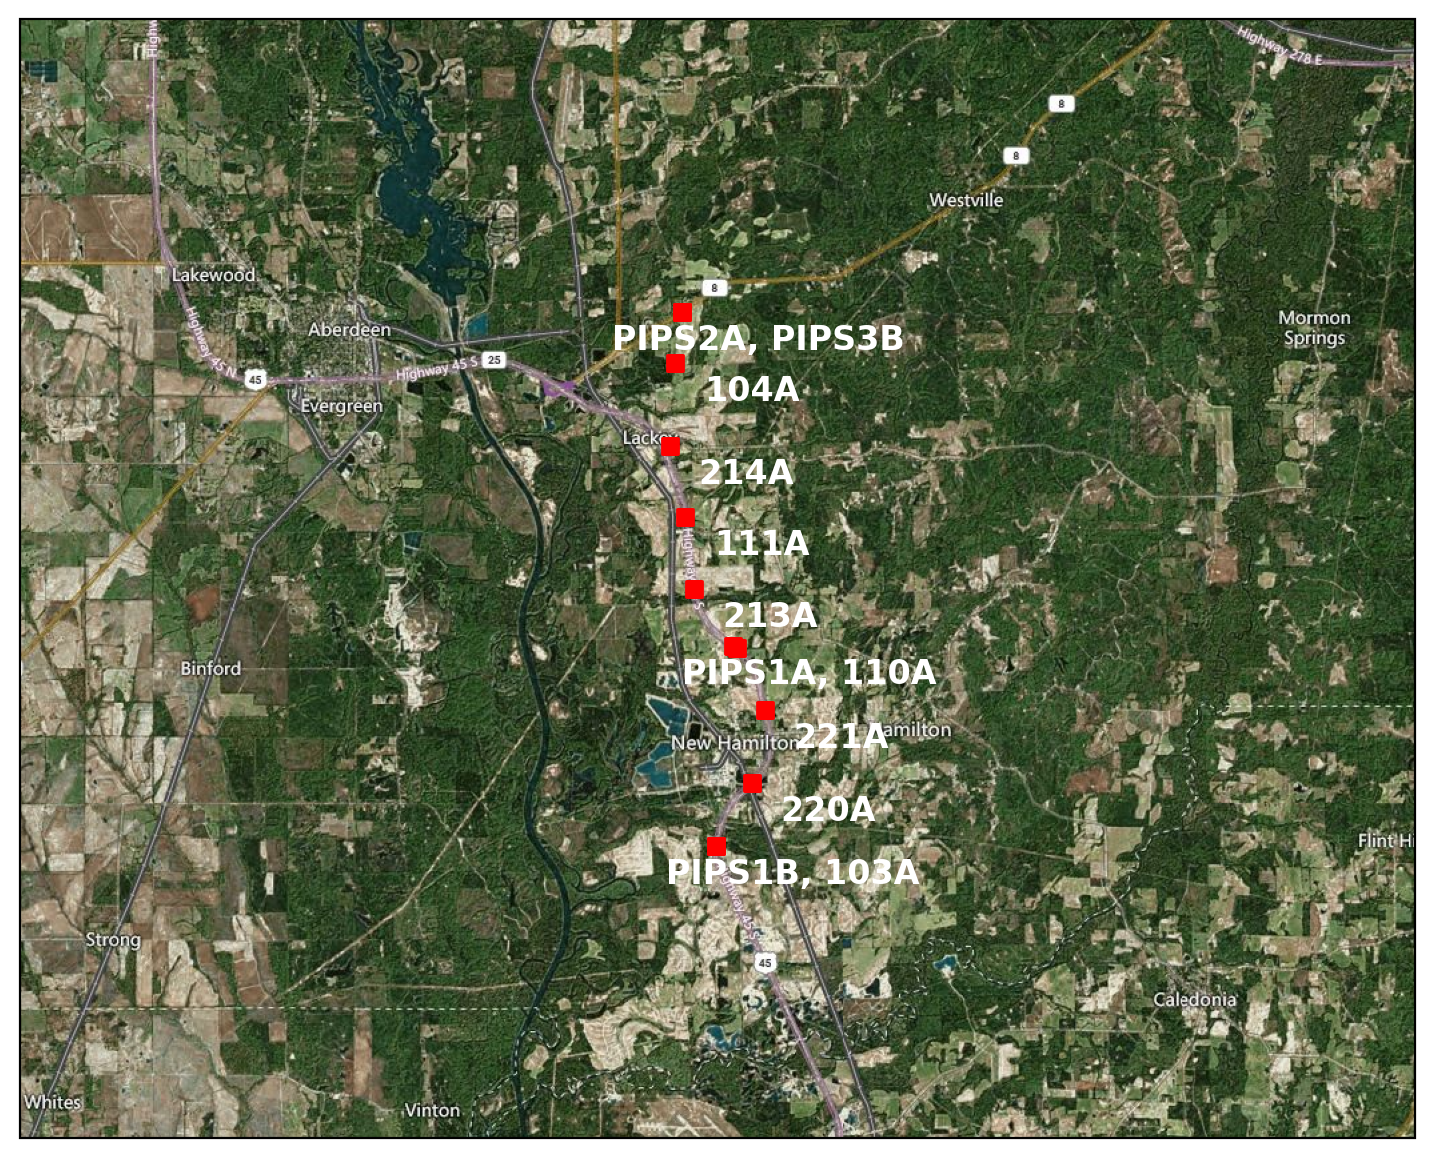

In [21]:
fig = plt.figure(figsize=(9,9)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
# location = eval(str(conv_ds.location))
center_pt = [clat, clon]
zoom = 0.12 # for zooming out of center point
lat_extent_mult = 1.5
extent = [center_pt[1]-(zoom*lat_extent_mult), center_pt[1]+(zoom*lat_extent_mult), 
          center_pt[0]-zoom, center_pt[0]+zoom] # adjust to zoom
ax1.set_extent(extent) # set extents
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
print(scale)
ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification
# NOTE: zoom specifications should be selected based on extent:
# -- 2     = coarse image, select for worldwide or continental scales
# -- 4-6   = medium coarseness, select for countries and larger states
# -- 6-10  = medium fineness, select for smaller states, regions, and cities
# -- 10-12 = fine image, select for city boundaries and zip codes
# -- 14+   = extremely fine image, select for roads, blocks, buildings

# mark locations of SN
ax1.scatter(lons_flat, lats_flat, marker='s', c='r', alpha=1, transform=ccrs.PlateCarree())

# For IOP2-2023 only, make two different station plots for each of the pairs, so that we can plot the text labels
# so they don't overlap. This is a pretty dumb hack but need something quick and dirty right now

stationplot1 = StationPlot(ax1, lons1, lats1, clip_on=True, transform=ccrs.PlateCarree(), fontsize=10)
if len(lons2) > 0:
    stationplot2 = StationPlot(ax1, lons2, lats2, clip_on=True, transform=ccrs.PlateCarree(), fontsize=10)
# stationplot.plot_parameter((-1.5,1), C_to_F(T_arr), color='#b30000', formatter='0.1f')
# stationplot.plot_parameter((-1.5,-1), C_to_F(Td_arr), color='darkgreen', formatter='0.1f')
# stationplot.plot_parameter((1.5,1), pressure_arr, formatter=lambda v: format(10 * v, '.0f')[-3:])
stationplot1.plot_text((2.75, -1.), all_names_concat, fontsize=12, weight='bold', color='white')
# if len(lons2) > 0:
#     stationplot2.plot_text((2.75, -2.25), names2, fontsize=12, weight='bold', color='red')

# for PIPS_name, conv_ds in conv_ds_dict.items():
#     lons = conv_ds['GPS_lon']
#     lons = lons.where(conv_ds['GPS_status'] == 'A', drop=True)
#     lats = conv_ds['GPS_lat']
#     lats = lats.where(conv_ds['GPS_status'] == 'A', drop=True)
#     times = conv_ds['time']
#     times = times.where(conv_ds['GPS_status'] == 'A', drop=True)
#     sc = ax1.scatter(lons, lats, c=times, marker='o', facecolor='none', alpha=1, transform=ccrs.PlateCarree())

# fig.colorbar(sc, ax=ax1)

# save figure 

plotdir = '/Users/dawson29/Dropbox/Projects/PERiLS/Documentation_for_EOL/'
plotname = f'{deployment_name}_overview.png'
plotpath = os.path.join(plotdir, plotname)
plt.savefig(plotpath, dpi=300, bbox_inches='tight')
# savedir = 'RT_tests' # hard coded real time directory
# nametime = parse_currtime()[1] # note that this may be different from last time on plot
#                              # THATS OKAY... it will make data drops more apparent!
# plt.savefig('{0}/{1}_oban_{2}.png'.format(savedir,name,nametime),dpi=300,bbox_inches = 'tight')
plt.show() # show the plot

In [ ]:
# Old cells below. Check if there is anything important there and then get rid of them

In [ ]:
# Set up map
width_x = 500. # m
width_y = 500. # m

location = eval(str(conv_ds.location))
ctrlat = location[0]
ctrlon = location[1]

trulon = ctrlon
trulat1 = 35.
trulat2 = 45.
projection = ccrs.LambertConformal(ctrlon, ctrlat, false_easting=width_x/2., false_northing=width_y/2.,
                                   standard_parallels=[trulat1, trulat2])

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})

# ax.stock_img()
# Add coastlines and states
ax.coastlines()
land = feature.LAND
ax.add_feature(land) # , edgecolor='face', facecolor=feature.COLORS['land'])
states = feature.STATES
# states = feature.NaturalEarthFeature(category="cultural", scale="50m",
#                                      facecolor="none",
#                                      name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=1., edgecolor='k', alpha=0.5)
rivers = feature.RIVERS
ax.add_feature(rivers, linewidth=0.75, edgecolor='b', alpha=0.5)
ax.add_feature(feature.NaturalEarthFeature('cultural', 'roads', '10m'), facecolor='none', edgecolor='b')
# # Add counties if desired. TODO: add back more features here after testing

# # if runname == pc.runname_list[0] and time == time_list[0]:

# print("Reading counties from shapefile")
county_shapefile_location = '/Users/dawson29/Projects/pyCRMtools/data/shapefiles/county/countyp020'
counties = plotmod.read_shapefile(county_shapefile_location)
ax.add_feature(counties, linewidth=0.5, edgecolor='grey', alpha=0.5)

# Add urban areas
# urban_shapefile_location = '/Users/dawson29/Projects/pyCRMtools/data/shapefiles/urban2/tl_2008_us_cbsa'
# urban = plotmod.read_shapefile(urban_shapefile_location)
# ax.add_feature(urban, linewidth=0.5, facecolor='purple', edgecolor='none', alpha=0.25)

# Add more stuff from GADM database (EDIT: doesn't seem to add anything beyond counties)
# gadm_shapefile_location = '/Users/dawson29/Projects/pyCRMtools/data/shapefiles/gadm/gadm36_USA_2'
# gadm_shapes = plotmod.read_shapefile(gadm_shapefile_location)
# ax.add_feature(gadm_shapes, linewidth=0.5, edgecolor='purple', alpha=0.8)

ax.set_xlim(0., width_x)
ax.set_ylim(0., width_y)
# ax.scatter([ctrlon], [ctrlat], color='black', marker='o', facecolor='none', transform=ccrs.PlateCarree())

lons = conv_ds['GPS_lon']
lats = conv_ds['GPS_lat']
ax.scatter(lons, lats, color='black', marker='o', facecolor='none', alpha=0.75, transform=ccrs.PlateCarree())

In [ ]:
print(wind_dir_conv.coords['time'])
print(len(wind_dir_conv.time))
print(len(np.unique(wind_dir_conv.time.data)))
unique_times = np.unique(wind_dir_conv['time'])
print(unique_times)
duplicated = wind_dir_conv.indexes['time'].duplicated()
print(duplicated)
dup_indices = np.where(duplicated)[0]
print(dup_indices)
#duplicated = xr.DataArray(parsivel_ds_read.indexes['time'].duplicated())
duplicated_times = wind_dir_conv['time'].isel(time=dup_indices)
print(duplicated_times)
duplicated_times_only = wind_dir_conv.isel(time=dup_indices)
print(duplicated_times_only)

In [ ]:
time_diff = wind_spd_conv['time'].diff('time').astype(np.float)*1.e-9
print(time_diff)
out_of_order_times = time_diff.where(time_diff < 0, drop=True)['time']
print(out_of_order_times)

In [ ]:
int_indices = range(wind_spd_conv.sizes['time'])
print(wind_spd_conv.coords['time'].values)
int_ind_da = xr.DataArray(int_indices, coords=[('time', wind_spd_conv.coords['time'].values)])
print(int_ind_da)

In [ ]:
print(int_ind_da.sel(time='2017-04-30T20:40:18.000000000'))

In [ ]:
print(wind_spd_conv.isel(time=74415))
print(wind_spd_conv.isel(time=74416))
print(wind_spd_conv.isel(time=74417))
print(wind_spd_conv.isel(time=74418))

In [ ]:
time_diff = parsivel_ds['time'].diff('time').astype(np.float)*1.e-9
print(time_diff)
out_of_order_times = time_diff.where(time_diff < 0, drop=True)['time']
print(out_of_order_times)

In [ ]:
PIPS_dir2 = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_new_test/'
parsivel_filepath2 = os.path.join(PIPS_dir, 'parsivel_combined_FMCW_2017_043017_PIPS2A_60s.nc')
conv_filepath2 = os.path.join(PIPS_dir, 'conventional_raw_FMCW_2017_043017_PIPS2A.nc')
parsivel_ds2 = xr.load_dataset(parsivel_filepath2)
conv_ds2 = xr.load_dataset(conv_filepath2)

In [ ]:
time_diff = parsivel_ds2['time'].diff('time').astype(np.float)*1.e-9
print(time_diff)
out_of_order_times = time_diff.where(time_diff < 0, drop=True)['time']
print(out_of_order_times)